# Exploring AWS Public Blockchain Dataset

In [15]:
import pandas as pd

# Path to your local Parquet file
file_path = "./v1.0/btc/blocks/date=2021-01-28/part-00000-07e13b0c-d837-45e3-9d7f-1352c478ed55-c000.snappy.parquet"

# Read the Parquet file
df = pd.read_parquet(file_path)

# Display the first few rows
print(df.head())

                                                hash     version  \
0  00000000000000000003172093fcff9705da7519048ebe...   536870912   
1  00000000000000000004b3835952e30039dcbccb1b0ba5...   805298176   
2  00000000000000000000109cc8faade73eaded7d9ebf29...  1073733632   
3  000000000000000000049dae6ac421012c91d44b1ea7af...   671080448   
4  000000000000000000056cce6e8dba8eb5ff9750f1358b...   541065216   

           mediantime       nonce      bits    difficulty  \
0 2021-01-28 17:16:02  2786007068  170d8457  2.082353e+13   
1 2021-01-28 03:48:43  2759903233  170d8457  2.082353e+13   
2 2021-01-28 08:23:36  2323570707  170d8457  2.082353e+13   
3 2021-01-28 14:39:32  2904890703  170d8457  2.082353e+13   
4 2021-01-28 17:53:17  3846823593  170d8457  2.082353e+13   

                                           chainwork  \
0  000000000000000000000000000000000000000018b0eb...   
1  000000000000000000000000000000000000000018aa2f...   
2  000000000000000000000000000000000000000018ac7a...   


In [11]:
print(df.info())

# Summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   hash               145 non-null    object        
 1   version            145 non-null    int64         
 2   mediantime         145 non-null    datetime64[ns]
 3   nonce              145 non-null    int64         
 4   bits               145 non-null    object        
 5   difficulty         145 non-null    float64       
 6   chainwork          145 non-null    object        
 7   previousblockhash  145 non-null    object        
 8   size               145 non-null    int64         
 9   weight             145 non-null    int64         
 10  coinbase_param     145 non-null    object        
 11  number             145 non-null    int64         
 12  transaction_count  145 non-null    int64         
 13  merkle_root        145 non-null    object        
 14  stripped_s

In [19]:
# Sort the DataFrame by the 'timestamp' column
df_sorted = df.sort_values(by='timestamp')

# Reset the index after sorting
df_sorted.reset_index(drop=True, inplace=True)

# Verify the order
print(df_sorted['timestamp'])


0     2021-01-28 00:34:47
1     2021-01-28 00:49:37
2     2021-01-28 01:01:26
3     2021-01-28 01:03:35
4     2021-01-28 01:32:45
              ...        
140   2021-01-28 23:27:32
141   2021-01-28 23:29:18
142   2021-01-28 23:30:21
143   2021-01-28 23:40:20
144   2021-01-28 23:41:13
Name: timestamp, Length: 145, dtype: datetime64[ns]


In [23]:
df_sorted.iloc[0,0]

'000000000000000000033603ee318f49b02dd2bc1c9e400e6e20d81fe184f338'

In [24]:
df_sorted.iloc[0,:]

hash                 000000000000000000033603ee318f49b02dd2bc1c9e40...
version                                                      939515904
mediantime                                         2021-01-27 23:26:59
nonce                                                        337490073
bits                                                          170d8457
difficulty                                       20823531150111.519531
chainwork            000000000000000000000000000000000000000018a8a1...
previousblockhash    00000000000000000002304bc1c3e870d0bdb3c5e315b8...
size                                                           1386156
weight                                                         3998637
coinbase_param       0343310a2cfabe6d6d065aeed33ce7ccc3cc4ac2860ca8...
number                                                          667971
transaction_count                                                 2975
merkle_root          5f68f9fdfbb1fcffd845c0c8dd120fc65c13cdb0a04c7a...
stripp

# Exploring Blockchair Data Dump

In [22]:
from datetime import date, timedelta
import os
import requests
import pandas as pd
import gzip
import shutil
import csv

def download_and_combine_files(types, start_date, end_date, output_filename="combined_data"):
    """Downloads files and combines them into a single gzipped TSV file."""

    for type in types:
        final = []
        current_date = start_date
        while current_date <= end_date:
            formatted_date = current_date.strftime("%Y%m%d")
            file_url = f"https://gz.blockchair.com/bitcoin/{type}/blockchair_bitcoin_{type}_{formatted_date}.tsv.gz"

            response = requests.get(file_url, stream=True)
            

            if response.status_code == 200:
                temp_filename = f"temp_{formatted_date}.tsv.gz" # Temporary files
                with open(temp_filename, "wb") as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
                with gzip.open(temp_filename, "rt") as f: 
                    l = list(csv.reader(f, delimiter="\t"))
                    final += (l[1:] if final else l)  
                os.remove(temp_filename)   
                print(f"Downloaded: {file_url}")
            else:
                print(f"Error downloading {file_url}: {response.status_code}")

            current_date += timedelta(days=1)
        
        df = pd.DataFrame(final[1:], columns=final[0])
        df.to_csv(f"{output_filename}_{type}.csv", index=False)
    

def read_combined_data(filename="combined_data_inputs.csv"):
    """Reads combined data from a gzipped TSV file into a Pandas DataFrame."""
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filename}' is empty.")
        return None
    except Exception as e: # Catch other potential exceptions during reading
        print(f"An error occurred while reading the file: {e}")
        return None

# usage
types = ["inputs", "transactions", "outputs"]
start_date = date(2010, 2, 1)
end_date = date(2010, 2, 10)

download_and_combine_files(types, start_date, end_date)

Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100201.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100202.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100203.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100204.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100205.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100206.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100207.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100208.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100209.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/inputs/blockchair_bitcoin_inputs_20100210.tsv.gz
Downloaded: https://gz.blockchair.com/bitcoin/tran

In [50]:
print(read_combined_data("combined_data_inputs.csv").shape)
read_combined_data("combined_data_inputs.csv")

(1522, 21)


,block_id,transaction_hash,index,time,value,value_usd,recipient,type,script_hex,is_from_coinbase,...,spending_block_id,spending_transaction_hash,spending_index,spending_time,spending_value_usd,spending_sequence,spending_signature_hex,spending_witness,lifespan,cdd
0,37389,d9a4176d14dbb00d6b798a30b32243af455be181f3cd2b...,0,2010-01-31 08:28:21,35000000000,3.50,1JvrS4xpuKiiiB51w1Mwewrspx2BVBkJSr,pubkey,4104e3a564a42717a9d4c15f47b33adf96d2a6286bf6dd...,0,...,37503,a41bb1b3f8ce6b1d9cf7bd7a8707efeb7316dd5ba11549...,0,2010-02-01 00:41:31,3.50,4294967295,493046022100c602ba8ef022965fc25dc3a33fe1a6e5ff...,NaN,58390,236.533565
1,37503,a41bb1b3f8ce6b1d9cf7bd7a8707efeb7316dd5ba11549...,1,2010-02-01 00:41:31,34900000000,3.49,14DBT1FZkzR7SjZv4cghhTJxJYCwDP3M24,pubkey,4104dcf9e313efd7aec54c423d25a559a83311ec3574f5...,0,...,37513,8697331c3124c8a4cf2f43afb5732374ea13769e42f10a...,0,2010-02-01 01:43:32,3.49,4294967295,483045022100eaa5542714d1e31eada58c31e6ac77774a...,NaN,3721,15.030428
2,37503,a41bb1b3f8ce6b1d9cf7bd7a8707efeb7316dd5ba11549...,0,2010-02-01 00:41:31,100000000,0.01,14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY,pubkeyhash,76a91427d25a1ff9a6da31eeb991c48bb6cd95191a6b2c...,0,...,37514,60748843bb13a8239a91505cbb4eeabc8b3d1f6ed1fdf9...,0,2010-02-01 01:47:30,0.01,4294967295,4830450221009b9e20ad2cf6715af44cadf588f14155cc...,NaN,3959,0.045822
3,37513,8697331c3124c8a4cf2f43afb5732374ea13769e42f10a...,1,2010-02-01 01:43:32,20000000000,2.00,16KkRwwdyoZPYpcBqUbM8YrifGyLjcJdj7,pubkey,4104d4ae60e43fd37ed680f40f86576f54fc57f61d3da0...,0,...,37514,acb2e895a9b3664cfcfb13dd0321ef0c1205cf2aa08268...,0,2010-02-01 01:47:30,2.00,4294967295,4730440220106c316c22d4bf8c970f8e4b1af1edd95121...,NaN,238,0.550926
4,37513,8697331c3124c8a4cf2f43afb5732374ea13769e42f10a...,0,2010-02-01 01:43:32,14900000000,1.49,1C3XZVD7J3UmNCFZYHiTRGL2X726ACWmW4,pubkey,41042f40514a99be39b3e94345455f78c4dfbbcd7f9cc6...,0,...,37521,a55aab1f308278fb57a87617645f3f9a7bf9cd97b0aab3...,0,2010-02-01 02:40:35,1.49,4294967295,473044022044547a1a1471a1cfcf3c438b34e46e7b5b67...,NaN,3423,5.903090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,39050,0cfbc55a518a9fd9e6f17dfa7aef31212e5532e2e9b98e...,0,2010-02-08 10:43:49,5000000000,0.50,19f5PDoH5e53fDQkGyDtA3GbkJjTpgxKWQ,pubkey,4104944e83380798633d3c3b1f3189bf4eb5c51dd2d1b8...,1,...,39418,85ffd3cb2dd1713b38e81abfbc3fd588f2c3574a1d651d...,0,2010-02-10 08:22:01,0.50,4294967295,483045022100be8fe6b47e960eeea903ab1423a1f81813...,NaN,164292,95.076389
1518,39150,24e211bf6e0f05bac09a94554e1b25487c2d093d298c79...,0,2010-02-08 23:30:53,5000000000,0.50,168nsDjwH2ceV8fnMYzxu22Cr4vzDnfFHS,pubkey,4104cdde0a0df62f60d5b3858bc0d9b113332a142c59fb...,1,...,39418,85ffd3cb2dd1713b38e81abfbc3fd588f2c3574a1d651d...,1,2010-02-10 08:22:01,0.50,4294967295,473044022069e36bf4588fcee10033db4db6ca74934054...,NaN,118268,68.442130
1519,38919,9aad27f7dba26e2a77647e208f8b6a0039e54d15d9402a...,0,2010-02-07 20:04:00,5000000000,0.50,1LDsTkfAS31Q9dRpKJ17QnwecZA2Py8Xgf,pubkey,4104bcae30ba2e66b9766d7b3219ba47ed032e87d03b07...,1,...,39418,85ffd3cb2dd1713b38e81abfbc3fd588f2c3574a1d651d...,2,2010-02-10 08:22:01,0.50,4294967295,493046022100ea52c48363ba6e93fc36656accdd7ef9b8...,NaN,217081,125.625579
1520,39222,19e0c3d6327810f61118879de9e642a9197328f897b2ee...,0,2010-02-09 07:22:50,5000000000,0.50,1Ge8anwCwo8urCMWQSRzsWcLVPFTSRkGwN,pubkey,4104d6cf8ea05a79512670a38d632f08ae2c3e2b95a4c2...,1,...,39418,85ffd3cb2dd1713b38e81abfbc3fd588f2c3574a1d651d...,3,2010-02-10 08:22:01,0.50,4294967295,47304402203ca3331436a032bbeb12c3f583f1e7332ab5...,NaN,89951,52.054977


In [51]:
print(read_combined_data("combined_data_outputs.csv").shape)
read_combined_data("combined_data_outputs.csv")

(2102, 11)


,block_id,transaction_hash,index,time,value,value_usd,recipient,type,script_hex,is_from_coinbase,is_spendable
0,37494,faf705b1dd0c22dc55b77fc436618118800ea9bd22f892...,0,2010-02-01 00:08:21,5000000000,0.5,17PeCY98XRyEK9DPk5c1PQoMj8muwJs1Q6,pubkey,4104f95172805de937ed767b5df88a5b1042e1439b3067...,1,1
1,37495,825b31b5c08174c85530c5a643cbcce2781d4b4ae6a9ee...,0,2010-02-01 00:10:53,5000000000,0.5,18Tt2YoxAwJBtphjfiGm8Zr3K8dL7edEWh,pubkey,410498b7e6384de6ec2f71391cd6c9338683aec655e4fe...,1,1
2,37496,f480fd66255fe9bafd9b730effeace78182c0eb5c06e95...,0,2010-02-01 00:12:59,5000000000,0.5,1M1L1qBstM4fEPLCLQDHpBtZANHosAGo1j,pubkey,41047db6122b297f34e5c4264adcd05223f6eb097f9905...,1,1
3,37497,d9d0a615902ad038de11f7fe8e49d044d8d1a77791e663...,0,2010-02-01 00:15:31,5000000000,0.5,13vzopiP2ZAxiM7EhZzHjrroQh2dmgFvJF,pubkey,41043d54556a5e9f8905b186618ac0e527c4f712231bd7...,1,1
4,37498,ff5c63a108eeea781b25e8ed90ac98204b528d29480f6e...,0,2010-02-01 00:17:36,5000000000,0.5,1C7C4GidhcfkjfpQBrbb12JShiQy4MtaxY,pubkey,410440df56a3fb9272ce8839d7e8ebdf8edf830ad8b7d8...,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2097,39524,acfb7aae31805767bf37d8d105db86d93fb4971ec54b6b...,0,2010-02-10 23:25:33,5000000000,0.5,14o5i5ra4Tah5iAtqTB6CP8bqzf5shwHvf,pubkey,41041d94b2cd6bd8d0230ff43264657795afe72215d8ee...,1,1
2098,39525,65155704c4af70aca860be32e0bae8005aea77239884f5...,0,2010-02-10 23:39:31,5000000000,0.5,1HJrY88qasjucYHYchLMfiUpnyKBmvEdMs,pubkey,4104c9e33bec900a1ebd7e582fac55576ff8176e2a733a...,1,1
2099,39526,b91fb328bbdb56e32bd882c1b4aaf0aaa4c4ace7d32ad3...,0,2010-02-10 23:50:51,5000000000,0.5,1MQm8DGp9CrnMMwZ7fQfxZCk3SLWktBWhU,pubkey,41040fdd204e0b7586475cf2d398b3e813cb3845e9c91c...,1,1
2100,39527,f8c2da187ea3caf2c04ef306e365514c30e4c21e7d5534...,0,2010-02-10 23:53:45,5000000000,0.5,1bcGVd7u7ByyeDiyUR4ZY1rmxuzg1i4oJ,pubkey,4104f1a952c2dccb118d824dae67227f0195bf2450582c...,1,1


In [29]:
print(read_combined_data("combined_data_transactions.csv").shape)
read_combined_data("combined_data_transactions.csv").head()

(2091, 22)


,block_id,hash,time,size,weight,version,lock_time,is_coinbase,has_witness,input_count,...,input_total_usd,output_total,output_total_usd,fee,fee_usd,fee_per_kb,fee_per_kb_usd,fee_per_kwu,fee_per_kwu_usd,cdd_total
0,37494,faf705b1dd0c22dc55b77fc436618118800ea9bd22f892...,2010-02-01 00:08:21,135,540,1,0,1,0,1,...,0.0,5000000000,0.5,0,0.0,0,0.0,0,0,0.0
1,37495,825b31b5c08174c85530c5a643cbcce2781d4b4ae6a9ee...,2010-02-01 00:10:53,135,540,1,0,1,0,1,...,0.0,5000000000,0.5,0,0.0,0,0.0,0,0,0.0
2,37496,f480fd66255fe9bafd9b730effeace78182c0eb5c06e95...,2010-02-01 00:12:59,134,536,1,0,1,0,1,...,0.0,5000000000,0.5,0,0.0,0,0.0,0,0,0.0
3,37497,d9d0a615902ad038de11f7fe8e49d044d8d1a77791e663...,2010-02-01 00:15:31,135,540,1,0,1,0,1,...,0.0,5000000000,0.5,0,0.0,0,0.0,0,0,0.0
4,37498,ff5c63a108eeea781b25e8ed90ac98204b528d29480f6e...,2010-02-01 00:17:36,134,536,1,0,1,0,1,...,0.0,5000000000,0.5,0,0.0,0,0.0,0,0,0.0


# Graphs

In [94]:
def generate_edges(df_transaction, df_input, df_output, only_weights=True):
    edges = []
    for _, value in df_transaction.iterrows():
        if value["is_coinbase"]: continue
        t = value['hash']
        val = value['input_total_usd']
        fee = value['fee']

        t_input = df_input.loc[df_input["spending_transaction_hash"] == t]
        t_output = df_output.loc[df_output['transaction_hash'] == t]
        t_transaction = df_transaction[df_transaction['hash'] == t]

        if len(t_input) > 1 and len(t_output) > 1:
            print(t, len(t_input), len(t_output))

        if len(t_input) == 1: # dont need to account for transaction fee
            in_rep = t_input.iloc[0].loc['recipient']
            edges += [(
                in_rep, i.loc['recipient'], 
                (i.loc['value_usd'] if only_weights else {
                    "weight": i.loc['value_usd'],
                    "hash": t,
                    "is_spendable": i.loc['is_spendable']
                })
            ) for _,i in t_output.loc[t_output['is_from_coinbase'] == 0].iterrows()]

        if len(t_output) == 1: 
            out_rep = t_output.iloc[0].loc['recipient']
            edges += [(
                i.loc['recipient'], out_rep, 
                (i.loc['spending_value_usd'] if only_weights else {
                "weight": i.loc['spending_value_usd'] - (i.loc['spending_value_usd']/val * fee), # accounting for weighted transaction fees
                "hash": t,
                "is_spendable": i.loc['is_spendable']
                })
            ) for _,i in t_input.iterrows()]


    return edges


df_transaction = read_combined_data('combined_data_transactions.csv')
df_input = read_combined_data("combined_data_inputs.csv")
df_output = read_combined_data("combined_data_outputs.csv")

generate_edges(df_transaction, df_input, df_output)

45807808b04f84f4e8964b26a15e417af8f952492126e5b0f702514354810637 238 2
0f5007ea2f309b3609c08a6caab8986e04e7f064db2e2b68446c27c6e7c52232 381 2


[('1JvrS4xpuKiiiB51w1Mwewrspx2BVBkJSr',
  '14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY',
  0.01),
 ('1JvrS4xpuKiiiB51w1Mwewrspx2BVBkJSr',
  '14DBT1FZkzR7SjZv4cghhTJxJYCwDP3M24',
  3.49),
 ('14DBT1FZkzR7SjZv4cghhTJxJYCwDP3M24',
  '1C3XZVD7J3UmNCFZYHiTRGL2X726ACWmW4',
  1.49),
 ('14DBT1FZkzR7SjZv4cghhTJxJYCwDP3M24',
  '16KkRwwdyoZPYpcBqUbM8YrifGyLjcJdj7',
  2.0),
 ('14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY',
  '1D5faUoc4iJpegwCYSLcNmMiNd42rPzVLp',
  0.01),
 ('14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY',
  '1D5faUoc4iJpegwCYSLcNmMiNd42rPzVLp',
  0.01),
 ('16KkRwwdyoZPYpcBqUbM8YrifGyLjcJdj7',
  '181iyofcXEUif4kfxAymFeX9EtmfKQExPL',
  0.99),
 ('16KkRwwdyoZPYpcBqUbM8YrifGyLjcJdj7',
  '14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY',
  1.01),
 ('1C3XZVD7J3UmNCFZYHiTRGL2X726ACWmW4',
  '1D5faUoc4iJpegwCYSLcNmMiNd42rPzVLp',
  1.49),
 ('14dZLztXXGSYuZDHBqHe7iXiCGNgLTfsdY',
  '1D5faUoc4iJpegwCYSLcNmMiNd42rPzVLp',
  1.01),
 ('181iyofcXEUif4kfxAymFeX9EtmfKQExPL',
  '17DC6Fxidja2DN7oHTVgfx3uQ4KGArYEwg',
  0.99),
 ('1LokUszDBeD5mzF4Qsw

45807808b04f84f4e8964b26a15e417af8f952492126e5b0f702514354810637 238 2
0f5007ea2f309b3609c08a6caab8986e04e7f064db2e2b68446c27c6e7c52232 381 2


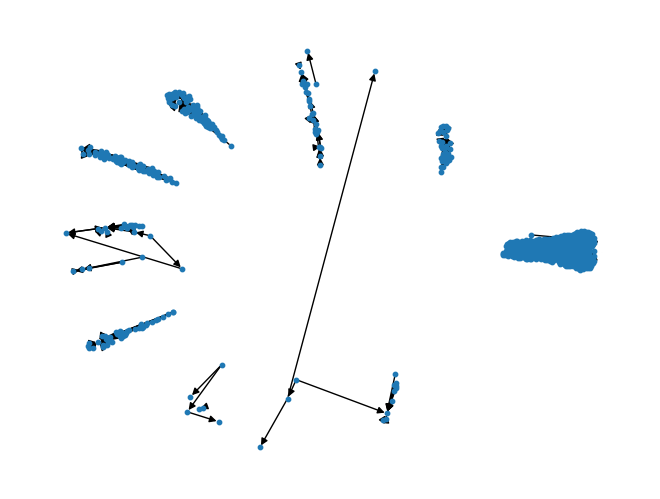

In [98]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph() # empty graph

df_transaction = read_combined_data('combined_data_transactions.csv')
df_input = read_combined_data("combined_data_inputs.csv")
df_output = read_combined_data("combined_data_outputs.csv")

edges = generate_edges(df_transaction, df_input, df_output)
G.add_weighted_edges_from(edges)
nx.draw(G, with_labels=False, font_weight='bold', node_size=10)
# plt.savefig("combined_graph.png")

45807808b04f84f4e8964b26a15e417af8f952492126e5b0f702514354810637 238 2
0f5007ea2f309b3609c08a6caab8986e04e7f064db2e2b68446c27c6e7c52232 381 2


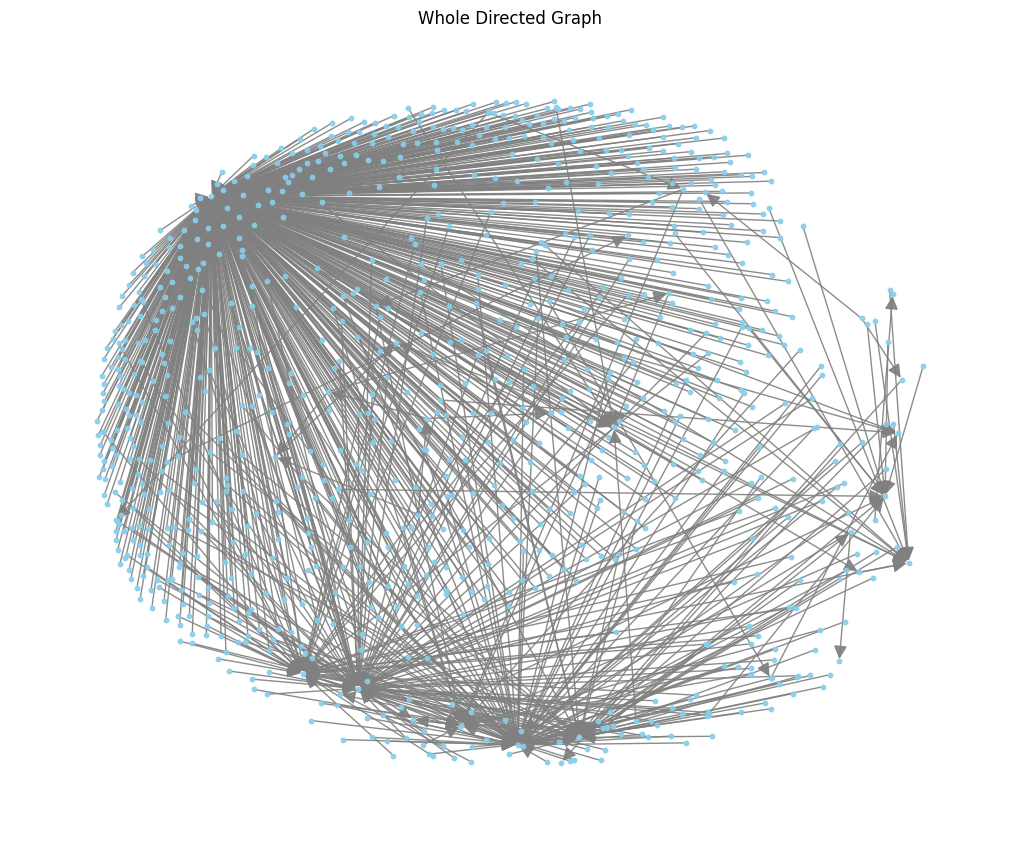

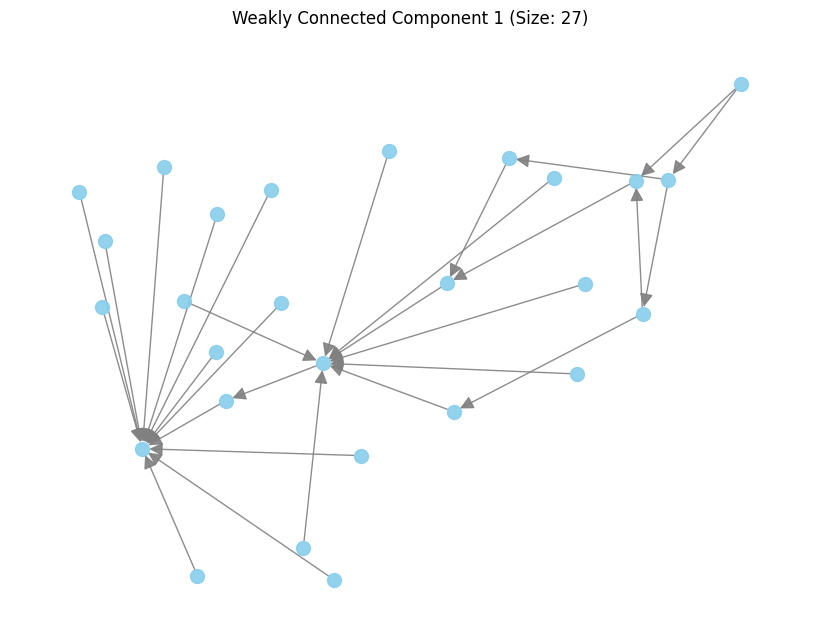

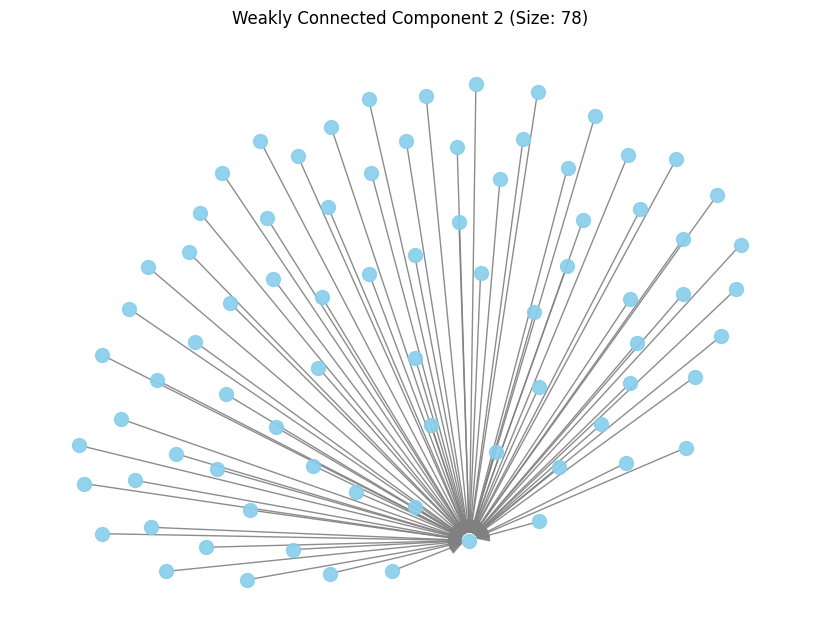

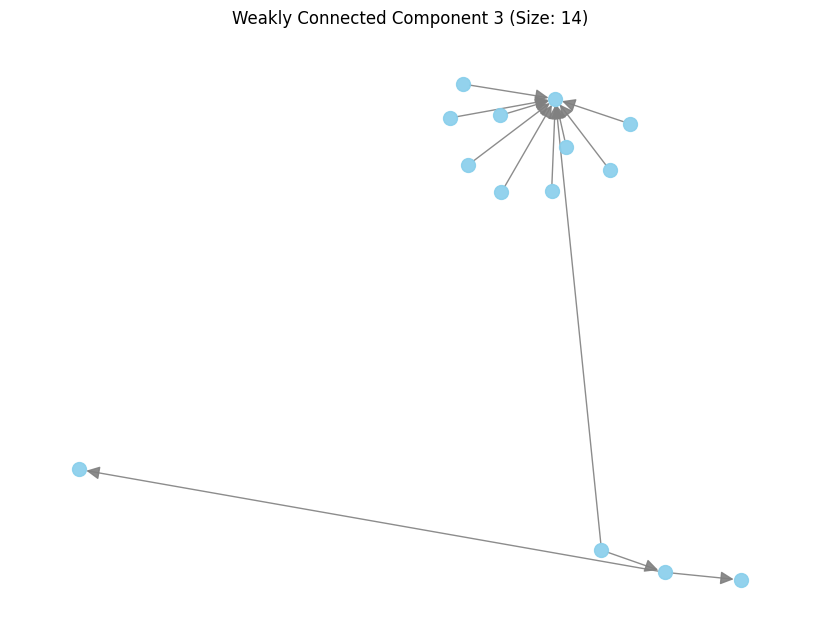

In [124]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_single_component_directed(graph, component_index=0, strongly_connected=True):
    """
    Plots a single (strongly or weakly) connected component of a directed graph.

    Args:
        graph: The NetworkX directed graph.
        component_index: The index of the component to plot.
        strongly_connected: If True, uses strongly connected components; otherwise, uses weakly connected components.
    """

    if strongly_connected:
        components = list(nx.strongly_connected_components(graph))
        component_type = "Strongly"
    else:
        components = list(nx.weakly_connected_components(graph))
        component_type = "Weakly"

    if not components:
        print("Graph is empty or has no connected components.")
        return

    if component_index < 0 or component_index >= len(components):
        print(f"Invalid component index. There are {len(components)} {component_type.lower()} connected components.")
        return

    component = components[component_index]
    subgraph = graph.subgraph(component)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subgraph, k=0.3, iterations=50)  # Or any other layout
    nx.draw(subgraph, pos, with_labels=False, node_size=100, node_color="skyblue", font_size=10,
            node_shape='o', alpha=0.9, linewidths=1, width=1, edge_color="gray",
            arrowstyle="-|>", arrowsize=20) #Added arrow parameters
    plt.title(f"{component_type} Connected Component {component_index + 1} (Size: {len(component)})")
    plt.show()

# Example Usage:
digraph = nx.DiGraph()
# digraph.add_edges_from([(1, 2), (2, 3), (3, 1), (4,5), (5,6)])  # Two strongly connected components
# digraph.add_edge(3,4) #Now they are weakly connected
# digraph.add_node(7)
edges = generate_edges(df_transaction, df_input, df_output)
digraph.add_weighted_edges_from(edges)


# Plot the whole graph
plt.figure(figsize=(10,8))
pos = nx.spring_layout(digraph, k=0.3, iterations=50)
nx.draw(digraph, pos, with_labels=False, node_size=10, node_color="skyblue", font_size=10,
            node_shape='o', alpha=0.9, linewidths=1, width=1, edge_color="gray",
            arrowstyle="-|>", arrowsize=20)
plt.title("Whole Directed Graph")
plt.show()

# # Strongly connected components
# plot_single_component_directed(digraph, component_index=0, strongly_connected=True)
# plot_single_component_directed(digraph, component_index=1, strongly_connected=True)
# plot_single_component_directed(digraph, component_index=2, strongly_connected=True)

# Weakly connected components
plot_single_component_directed(digraph, component_index=0, strongly_connected=False)
plot_single_component_directed(digraph, component_index=1, strongly_connected=False)
plot_single_component_directed(digraph, component_index=2, strongly_connected=False)

# # Empty Graph
# empty_digraph = nx.DiGraph()
# plot_single_component_directed(empty_digraph)

45807808b04f84f4e8964b26a15e417af8f952492126e5b0f702514354810637 238 2
0f5007ea2f309b3609c08a6caab8986e04e7f064db2e2b68446c27c6e7c52232 381 2


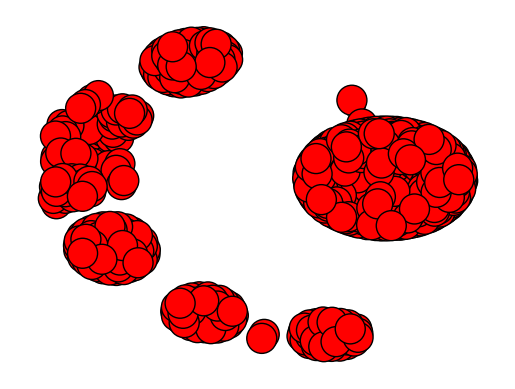

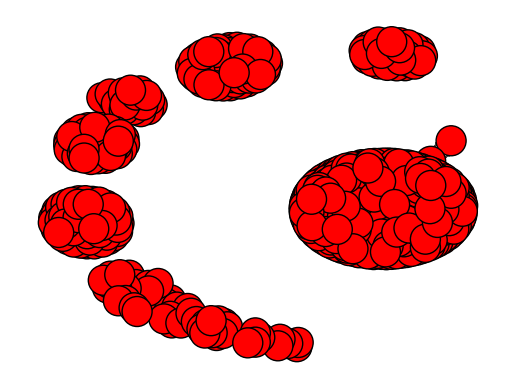

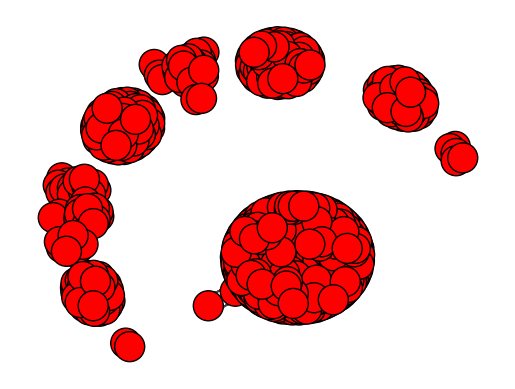

In [121]:
import igraph as ig
import cairo, cairocffi
import matplotlib.pyplot as plt 


def plot_directed_weighted_graph(edges, layout="kamada-kawai"):
    """
    Plots a directed weighted graph using igraph.

    Args:
        edges: A list of tuples representing the edges in the format (from, to, weight).
        layout: The layout algorithm to use (e.g., "kamada-kawai", "fruchterman-reingold", "circular").
    """

    # Create the graph
    graph = ig.Graph.TupleList(edges, directed=True, weights=True)

    # Set edge weights for visualization (adjust scaling as needed)
    edge_weights = graph.es["weight"]
    max_weight = max(edge_weights)
    graph.es["width"] = [weight / (max_weight/5) +1 for weight in edge_weights] # Scale width for better visualization
    graph.es["arrow_size"] = 0.5
    graph.es["arrow_width"] = 0.5

    # Set node labels (if you have them)
    # If not, igraph will use node indices
    # Example: graph.vs["name"] = ["Node A", "Node B", "Node C", ...]

    # Choose a layout algorithm
    if layout == "kamada-kawai":
        graph_layout = graph.layout_kamada_kawai()
    elif layout == "fruchterman-reingold":
        graph_layout = graph.layout_fruchterman_reingold()
    elif layout == "circular":
        graph_layout = graph.layout_circular()
    elif layout == "auto":
        graph_layout = graph.layout_auto()
    else:
        graph_layout = graph.layout_kamada_kawai()  # Default to Kamada-Kawai

    # # Plot the graph
    # ig.plot(
    #     graph,
    #     layout=graph_layout,
    #     vertex_size=30,
    #     vertex_color="lightblue",
    #     edge_color="gray",
    #     vertex_label=graph.vs["name"] if "name" in graph.vs else None,  # Display node labels if available
    #     edge_width=graph.es["width"], #use the scaled width
    #     edge_arrow_size=graph.es["arrow_size"],
    #     edge_arrow_width=graph.es["arrow_width"],
    #     edge_label=graph.es["weight"], # Display weight labels
    #     edge_label_color="black",
    #     edge_label_size=10
    # )

    fig, ax = plt.subplots()
    ig.plot(graph, target=ax)


# Example usage:
df_transaction = read_combined_data('combined_data_transactions.csv')
df_input = read_combined_data("combined_data_inputs.csv")
df_output = read_combined_data("combined_data_outputs.csv")

edges = generate_edges(df_transaction, df_input, df_output)

plot_directed_weighted_graph(edges, layout="kamada-kawai") #You can change the layout here
plot_directed_weighted_graph(edges, layout="fruchterman-reingold")
plot_directed_weighted_graph(edges, layout="auto")

# # Example with numerical nodes and labels:
# edges_numeric = [(0, 1, 5), (0, 2, 2), (1, 2, 3), (2, 0, 1), (2, 3, 4), (3, 1, 6)]
# graph_numeric = ig.Graph.TupleList(edges_numeric, directed=True, weights=True)
# graph_numeric.vs["name"] = ["Node 0", "Node 1", "Node 2", "Node 3"] #Add labels
# plot_directed_weighted_graph(edges_numeric)

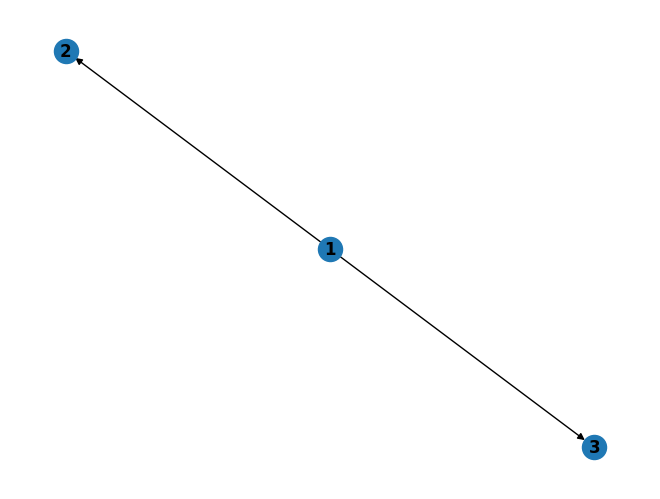

In [49]:
import matplotlib.pyplot as plt

# G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')
